In [1]:
import pandas as pd

df = pd.read_csv('archive\SPAM text message 20170820 - Data.csv')
df = df[['Category','Message']]
size = df.shape[0]
df.index = range(size)
total_word_count = df['Message'].apply(lambda x : len(x.split(' '))).sum()

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Category_encoded'] = le.fit_transform(df['Category'])

import re
def cleantext(text):
    text = re.sub(r"http\S+",r'<URL>',text )
    text = text.lower()
    
    return text

df['Message'] = df['Message'].apply(cleantext)

df = df.drop(columns=['Category'])

from tensorflow.keras.preprocessing.text import Tokenizer
import math
max_vocab_size = math.floor(total_word_count*0.15)

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<oov>" , filters='!@#$%^&*()_+{;}|:"<>?', lower=True)

tokenizer.fit_on_texts(df['Message'])

sequences = tokenizer.texts_to_sequences(df['Message'])

vocabulary_size = len(tokenizer.word_index) +1

from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 100
X = pad_sequences(sequences,
                  maxlen = max_length,
                  padding = 'post',
                  truncating='post')

y = df['Category_encoded'].values


from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.2,random_state=42
)

# Print split info
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Training spam ratio: {y_train.mean():.3f}")
print(f"Testing spam ratio: {y_test.mean():.3f}")

Training samples: 4457
Testing samples: 1115
Training spam ratio: 0.134
Testing spam ratio: 0.134


In [2]:
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, SpatialDropout1D, Flatten
from tensorflow.keras import Input
from tensorflow.keras.models import load_model, Model, Sequential
from attention import Attention
import tensorflow as tf

embedding_dim = 128
lstm_units = 64

inputs = Input(shape=(max_length,))
        
embedding = Embedding(input_dim = min(vocabulary_size,max_vocab_size),
                    output_dim = embedding_dim,
                    input_length = max_length)(inputs)
embedding = SpatialDropout1D(0.2)(embedding)

lstm_out = LSTM(lstm_units, return_sequences=True, dropout=0.2,
               recurrent_dropout=0.2, 
              )(embedding)
lstm_out2 = LSTM(lstm_units//2, return_sequences =True, dropout = 0.2, recurrent_dropout =  0.2)(lstm_out)

# # Attention mechanism

# attention = tf.keras.layers.Activation('softmax')(lstm_out2)
# attention = tf.keras.layers.RepeatVector(lstm_units//2)(attention)
# attention = tf.keras.layers.Permute([2, 1])(attention)

# sent_representation = tf.keras.layers.multiply([lstm_out2, attention])
# sent_representation = tf.keras.layers.Lambda(
#     lambda x: tf.keras.backend.sum(x, axis=1)
# )(sent_representation)

def attention_layer(inputs):
    # inputs shape: (batch_size, time_steps, features)
    attention_weights = tf.nn.softmax(tf.reduce_sum(inputs, axis=-1, keepdims=True), axis=1)
    # attention_weights shape: (batch_size, time_steps, 1)
    
    weighted_input = inputs * attention_weights
    # weighted_input shape: (batch_size, time_steps, features)
    
    output = tf.reduce_sum(weighted_input, axis=1)
    # output shape: (batch_size, features)
    return output

sent_representation = tf.keras.layers.Lambda(attention_layer)(lstm_out2)

dense = Dense(32, activation='relu')(sent_representation)
dense = Dropout(0.2)(dense)
outputs = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0, # minimum change in the monitored quality to qualify as improvement
    patience = 10, # number of epochs with no improvements after which training will be stopped
    verbose = 1, #1 displays the message when the callback takes an action
    mode = 'auto',
    #One of {"auto", "min", "max"}.
    # In min mode, training will stop when the quantity monitored has stopped decreasing;
    # in "max" mode it will stop when the quantity monitored has stopped increasing;
    #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity. Defaults to "auto".
    restore_best_weights =True
)
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2, #factor by which the learning rate will be reduced lr*factor
    patience =5, #num,ber of epochs with no improvement after which learning rate will be reduced
    verbose = 1, # for updaing the messages
    mode = 'auto',
    min_lr = 0.001 #lowerbound for learning rate
    
    
)

callbacks = [early_stopping,reduce_lr]

print("\nStarting training...")
batch_size = 32
epochs = 50

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)



C:\Users\Bachu Sai Raj\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 128)       │     1,541,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,604,673 (6.12 MB)

 Trainable params: 1,604,673 (6.12 MB)

 Non-trainable params: 0 (0.00 B)

None

Starting training...
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9215 - loss: 0.2231 - val_accuracy: 0.9848 - val_loss: 0.0615 - learning_rate: 0.0010
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.9895 - loss: 0.0424 - val_accuracy: 0.9848 - val_loss: 0.0603 - learning_rate: 0.0010
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.9962 - loss: 0.0203 - val_accuracy: 0.9865 - val_loss: 0.0572 - learning_rate: 0.0010
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.9987 - loss: 0.0076 - val_accuracy: 0.9857 - val_loss: 0.0574 - learning_rate: 0.0010
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - accuracy: 0.9993 - loss: 0.0054 - val_accuracy: 0.9874 - val_loss: 0.0564 - learning_rate: 0.0010
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.9998 - loss: 0.0017 - val_accuracy: 0.9857 - val_loss: 0.0651 - learning_rate: 0.0010
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 

In [3]:
# Save the trained model
model.save('lstm_2_layer_model.h5')
print("Model saved as 'lstm_2_layer_model.h5'")

model_json = model.to_json()
with open("lstm_2_layer_model_architecture.json", "w") as json_file:
    json_file.write(model_json)
print("Model architecture saved as JSON")

# Save only the weights (optional)
model.save_weights('lstm_2_layer_model.weights.h5')
print("Model weights saved")

Model saved as 'lstm_2_layer_model.h5'
Model architecture saved as JSON
Model weights saved


In [4]:
#lets make predictions

import numpy as np


print("predictions from model")

y_pred_prob = model.predict(X_test) # these are the model model probabilities

y_pred = (y_pred_prob > 0.5).astype(int) # these are the binary probabilities 0 or 1

#lets make predictions for the training set for the comparisions

y_train_pred_prob = model.predict(X_train)
y_train_pred = (y_train_pred_prob >0.5).astype(int)



predictions from model
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


In [5]:
# basic metrics

from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
print("="*50)
print("BASIC CLASSIFICATION PREDICTIONS")
print("="*50)

#test set metrics
# accuracy score is nothing but how many samples model precited correct
test_accuracy_score = accuracy_score(y_pred,y_test)
# Precision = Out of all the predicted positives, how many are actually correct (true positives).
test_precision_score = precision_score(y_pred, y_test)

# Recall = Out of all the actual positives, how many did we correctly identify.
test_recall_score = recall_score(y_pred, y_test) #
test_f1_score = f1_score(y_pred,y_test)


print("Test set basic predictions")
print("\n")
print(f"Test acccuracy score {test_accuracy_score}")
print(f"Test precison score {test_precision_score}")
print(f"Test recall score {test_recall_score}")
print(f"Test f1 score {test_f1_score}")


# train set metrics
train_accuracy_score = accuracy_score(y_train,y_train_pred)
train_precision_score = precision_score(y_train,y_train_pred)
train_recall_score = recall_score(y_train,y_train_pred)
train_f1_score = f1_score(y_train,y_train_pred)

print("\n")
print("="*50)
print("Train set basic predictions")
print("="*50)
print(f" Train acccuracy score {train_accuracy_score}")
print(f"Train precison score {train_precision_score}")
print(f"Train recall score {train_recall_score}")
print(f"Train f1 score {train_f1_score}")






BASIC CLASSIFICATION PREDICTIONS
Test set basic predictions


Test acccuracy score 0.9874439461883409
Test precison score 0.9463087248322147
Test recall score 0.9591836734693877
Test f1 score 0.9527027027027027


Train set basic predictions
 Train acccuracy score 0.9997756338344178
Train precison score 1.0
Train recall score 0.9983277591973244
Train f1 score 0.999163179916318


In [6]:
# lets check clasifcation report
from sklearn.metrics import classification_report
print("="*50)
print("Detailed Classification Reprt")
print("="*50)

print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

Detailed Classification Reprt
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       966
        Spam       0.96      0.95      0.95       149

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.97      1115
weighted avg       0.99      0.99      0.99      1115



In [7]:
# confusion matrix

from sklearn.metrics import confusion_matrix
print("="*50)
print("Detailed  Confusion matrix")
print("="*50)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(cm)

true_positive,false_positive,false_negative,true_negative = cm.ravel()

print(f" True Positive {true_positive}")
print(f" False Positive {false_positive}")
print(f" True Negative {true_negative}")
print(f" False Negative {false_negative}")

Detailed  Confusion matrix
[[960   6]
 [  8 141]]
 True Positive 960
 False Positive 6
 True Negative 141
 False Negative 8


Basically a roc( receiver operating characterstic ) and auc(area under the curve) are the terms to evaluate how good the classifaction model can distinguish between two classes

Roc is a graph that basically shows you how good the model can able to tell difference between classes at all posssible thresholds 
it plots true positv erate and false positve rate

AUC is generalyy a number that summarizes the roc curve, 
auc = 1, perfectly classification which mean s model is perfect
auc = 0.5 means model is generally is no better than the random guessing

auc >0.5 and closer to 1 is better

In [8]:
#lets calculate roc and auc score

from sklearn.metrics import roc_curve,auc

print("\n" + "="*50)
print("ROC-AUC METRICS")
print("="*50)

fpr,tpr, thresholds  = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr,tpr)

print(f"ROC-AUC Score: {roc_auc:.4f}")



ROC-AUC METRICS
ROC-AUC Score: 0.9952


lets calculate the precision recall curve which basically shows you how well model balnaces between precision which is how many predicted positves are actiually correct and recall which is how many actual positves are predicted right

In [9]:
from sklearn.metrics import precision_recall_curve,average_precision_score

print(precision_recall_curve(y_test, y_pred_prob))

precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_prob)
avg_precision = average_precision_score(y_test, y_pred_prob)
print(f"Average Precision Score: {avg_precision:.4f}")

(array([0.13363229, 0.13375224, 0.13387242, ..., 1.        , 1.        ,
       1.        ], shape=(1077,)), array([1.        , 1.        , 1.        , ..., 0.01342282, 0.00671141,
       0.        ], shape=(1077,)), array([1.1623547e-04, 1.1632706e-04, 1.1659937e-04, ..., 9.9991232e-01,
       9.9991244e-01, 9.9991304e-01], shape=(1076,), dtype=float32))
Average Precision Score: 0.9848


Training history analysis

In [10]:
print("\n" + "="*50)
print("TRAINING HISTORY ANALYSIS")
print("="*50)

print(locals())
# print(locals()) will print out all the variables 
# and their current values that exist in the current part of your code (like inside a function or a code cell).


TRAINING HISTORY ANALYSIS
{'__name__': '__main__', '__doc__': 'Automatically created module for IPython interactive environment', '__package__': None, '__loader__': None, '__spec__': None, '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '_ih': ['', 'import pandas as pd\n\ndf = pd.read_csv(\'archive\\SPAM text message 20170820 - Data.csv\')\ndf = df[[\'Category\',\'Message\']]\nsize = df.shape[0]\ndf.index = range(size)\ntotal_word_count = df[\'Message\'].apply(lambda x : len(x.split(\' \'))).sum()\n\nfrom sklearn.preprocessing import LabelEncoder\n\nle = LabelEncoder()\ndf[\'Category_encoded\'] = le.fit_transform(df[\'Category\'])\n\nimport re\ndef cleantext(text):\n    text = re.sub(r"http\\S+",r\'<URL>\',text )\n    text = text.lower()\n    \n    return text\n\ndf[\'Message\'] = df[\'Message\'].apply(cleantext)\n\ndf = df.drop(columns=[\'Category\'])\n\nfrom tensorflow.keras.preprocessing.text import Tokenizer\nimport math\nmax_vocab_si

In [11]:
if 'history' in locals():
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    
    print(f"Final Training Loss:     {final_train_loss:.4f}")
    print(f"Final Validation Loss:   {final_val_loss:.4f}")
    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    

Final Training Loss:     0.0000
Final Validation Loss:   0.0761
Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.9865


In [12]:
#lets check for overfitting

loss_diff = abs(final_val_loss - final_train_loss)
acc_diff = abs(final_train_acc - final_val_acc)

if loss_diff > 0.1 or acc_diff > 0.05:
        print("⚠️  Potential overfitting detected!")
else:
        print("✅ No significant overfitting detected.")


✅ No significant overfitting detected.


Generate some visualizations


matplotlib is the basic library for creating all kinds of plots (line, bar, scatter, etc.). It gives you full control but requires more code for nice-looking plots.

seaborn is built on top of matplotlib. It makes it easier to create attractive and informative statistical graphics with less code. Seaborn has better default styles and more advanced plot types (like heatmaps, violin plots, etc.).


GENERATING VISUALIZATIONS...


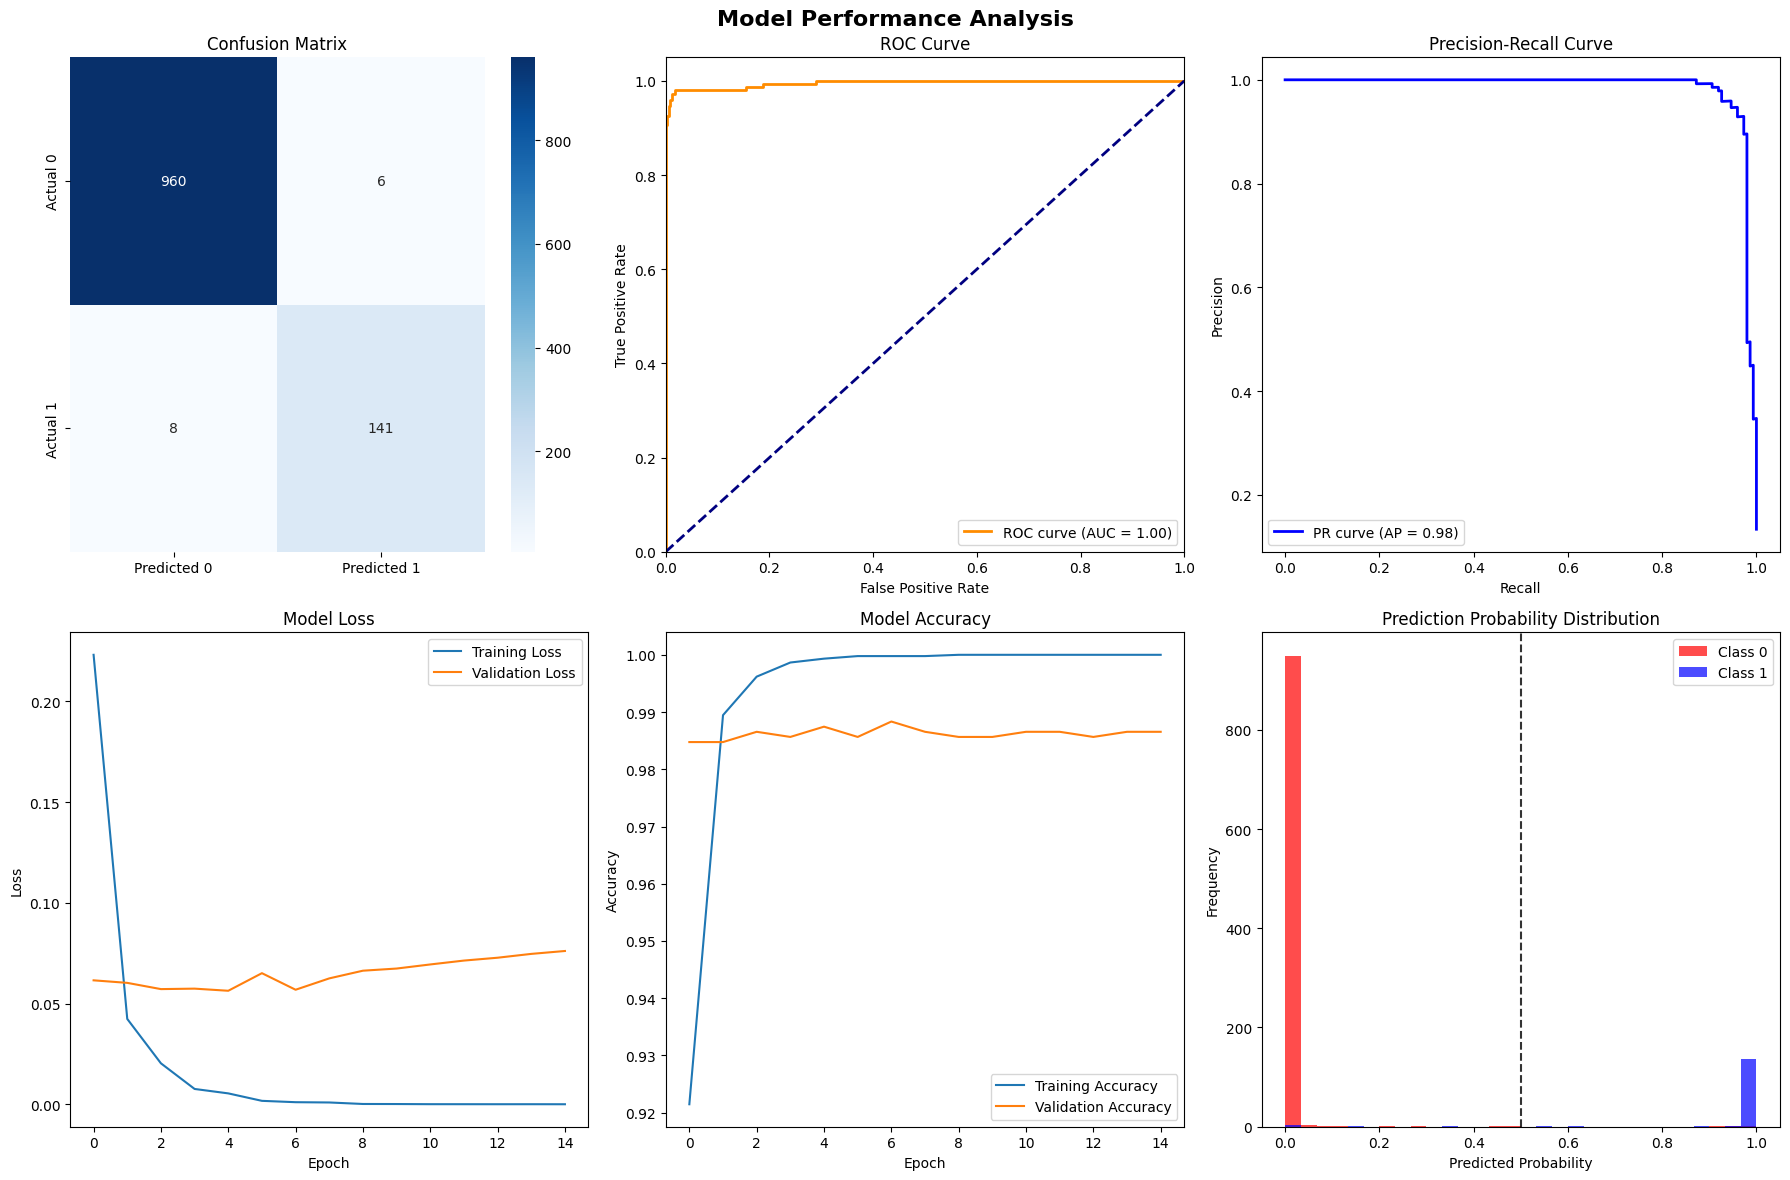

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*50)
print("GENERATING VISUALIZATIONS...")
print("="*50)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')

# Plot 1: Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'], ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')

# Plot 2: ROC Curve
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc="lower right")

# Plot 3: Precision-Recall Curve
axes[0,2].plot(recall_curve, precision_curve, color='blue', lw=2, 
              label=f'PR curve (AP = {avg_precision:.2f})')
axes[0,2].set_xlabel('Recall')
axes[0,2].set_ylabel('Precision')
axes[0,2].set_title('Precision-Recall Curve')
axes[0,2].legend(loc="lower left")

# Plot 4: Training History - Loss
if 'history' in locals():
    axes[1,0].plot(history.history['loss'], label='Training Loss')
    axes[1,0].plot(history.history['val_loss'], label='Validation Loss')
    axes[1,0].set_title('Model Loss')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Loss')
    axes[1,0].legend()

# Plot 5: Training History - Accuracy
if 'history' in locals():
    axes[1,1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[1,1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1,1].set_title('Model Accuracy')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].legend()

# Plot 6: Prediction Distribution
axes[1,2].hist(y_pred_prob[y_test==0], bins=30, alpha=0.7, label='Class 0', color='red')
axes[1,2].hist(y_pred_prob[y_test==1], bins=30, alpha=0.7, label='Class 1', color='blue')
axes[1,2].set_xlabel('Predicted Probability')
axes[1,2].set_ylabel('Frequency')
axes[1,2].set_title('Prediction Probability Distribution')
axes[1,2].legend()
axes[1,2].axvline(x=0.5, color='black', linestyle='--', alpha=0.8, label='Threshold')

plt.tight_layout()
plt.show()


In [16]:
# 9. METRICS SUMMARY TABLE
print("\n" + "="*50)
print("METRICS SUMMARY TABLE")
print("="*50)

metrics_summary = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC'],
    'Test Score': [
        test_accuracy_score,
        test_precision_score,
        test_recall_score,
        test_f1_score,
        roc_auc,
        avg_precision
    ],
    'Train Score': [
        train_accuracy_score,
        train_precision_score,
        train_recall_score,
        train_f1_score,
        'N/A',  # You can calculate train ROC-AUC if you want
        'N/A'   # You can calculate train PR-AUC if you want
    ]
}

import pandas as pd
df_metrics = pd.DataFrame(metrics_summary)
print(df_metrics.round(4))

# 10. SAVE RESULTS
print("\n" + "="*50)
print("SAVING RESULTS...")
print("="*50)

# Save metrics to file
with open('model_metrics_report.txt', 'w') as f:
    f.write("MODEL PERFORMANCE REPORT\n")
    f.write("="*50 + "\n\n")
    f.write(f"Test Accuracy: {test_accuracy_score:.4f}\n")
    f.write(f"Test Precision: {test_precision_score:.4f}\n")
    f.write(f"Test Recall: {test_recall_score:.4f}\n")
    f.write(f"Test F1-Score: {test_f1_score:.4f}\n")
    f.write(f"ROC-AUC: {roc_auc:.4f}\n")
    f.write(f"PR-AUC: {avg_precision:.4f}\n\n")
    f.write("Confusion Matrix:\n")
    f.write(str(cm) + "\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

print("✅ Metrics saved to 'model_metrics_report.txt'")
print("✅ All calculations completed!")


METRICS SUMMARY TABLE
      Metric  Test Score Train Score
0   Accuracy      0.9874    0.999776
1  Precision      0.9463         1.0
2     Recall      0.9592    0.998328
3   F1-Score      0.9527    0.999163
4    ROC-AUC      0.9952         N/A
5     PR-AUC      0.9848         N/A

SAVING RESULTS...
✅ Metrics saved to 'model_metrics_report.txt'
✅ All calculations completed!


Getting predictions...
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step

BASIC CLASSIFICATION METRICS
Test Accuracy:  0.9919
Test Precision: 0.9930
Test Recall:    0.9463
Test F1-Score:  0.9691

Train Accuracy:  1.0000
Train Precision: 1.0000
Train Recall:    1.0000
Train F1-Score:  1.0000

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0       0.99      1.00      1.00       966
     Class 1       0.99      0.95      0.97       149

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115


CONFUSION MATRIX
Confusion Matrix:
[[965   1]
 [  8 141]]

True Negatives:  965
False Positives: 1
False Negatives: 8
True Positives:  141

Specificity (True Negative Rate): 0.9990
Sensitivity (True Positive Rate): 0.9463

ROC-AUC METRICS
ROC-AUC Score: 0.9925

PRECISION-RECALL METRICS
Average Precision Score: 0.98

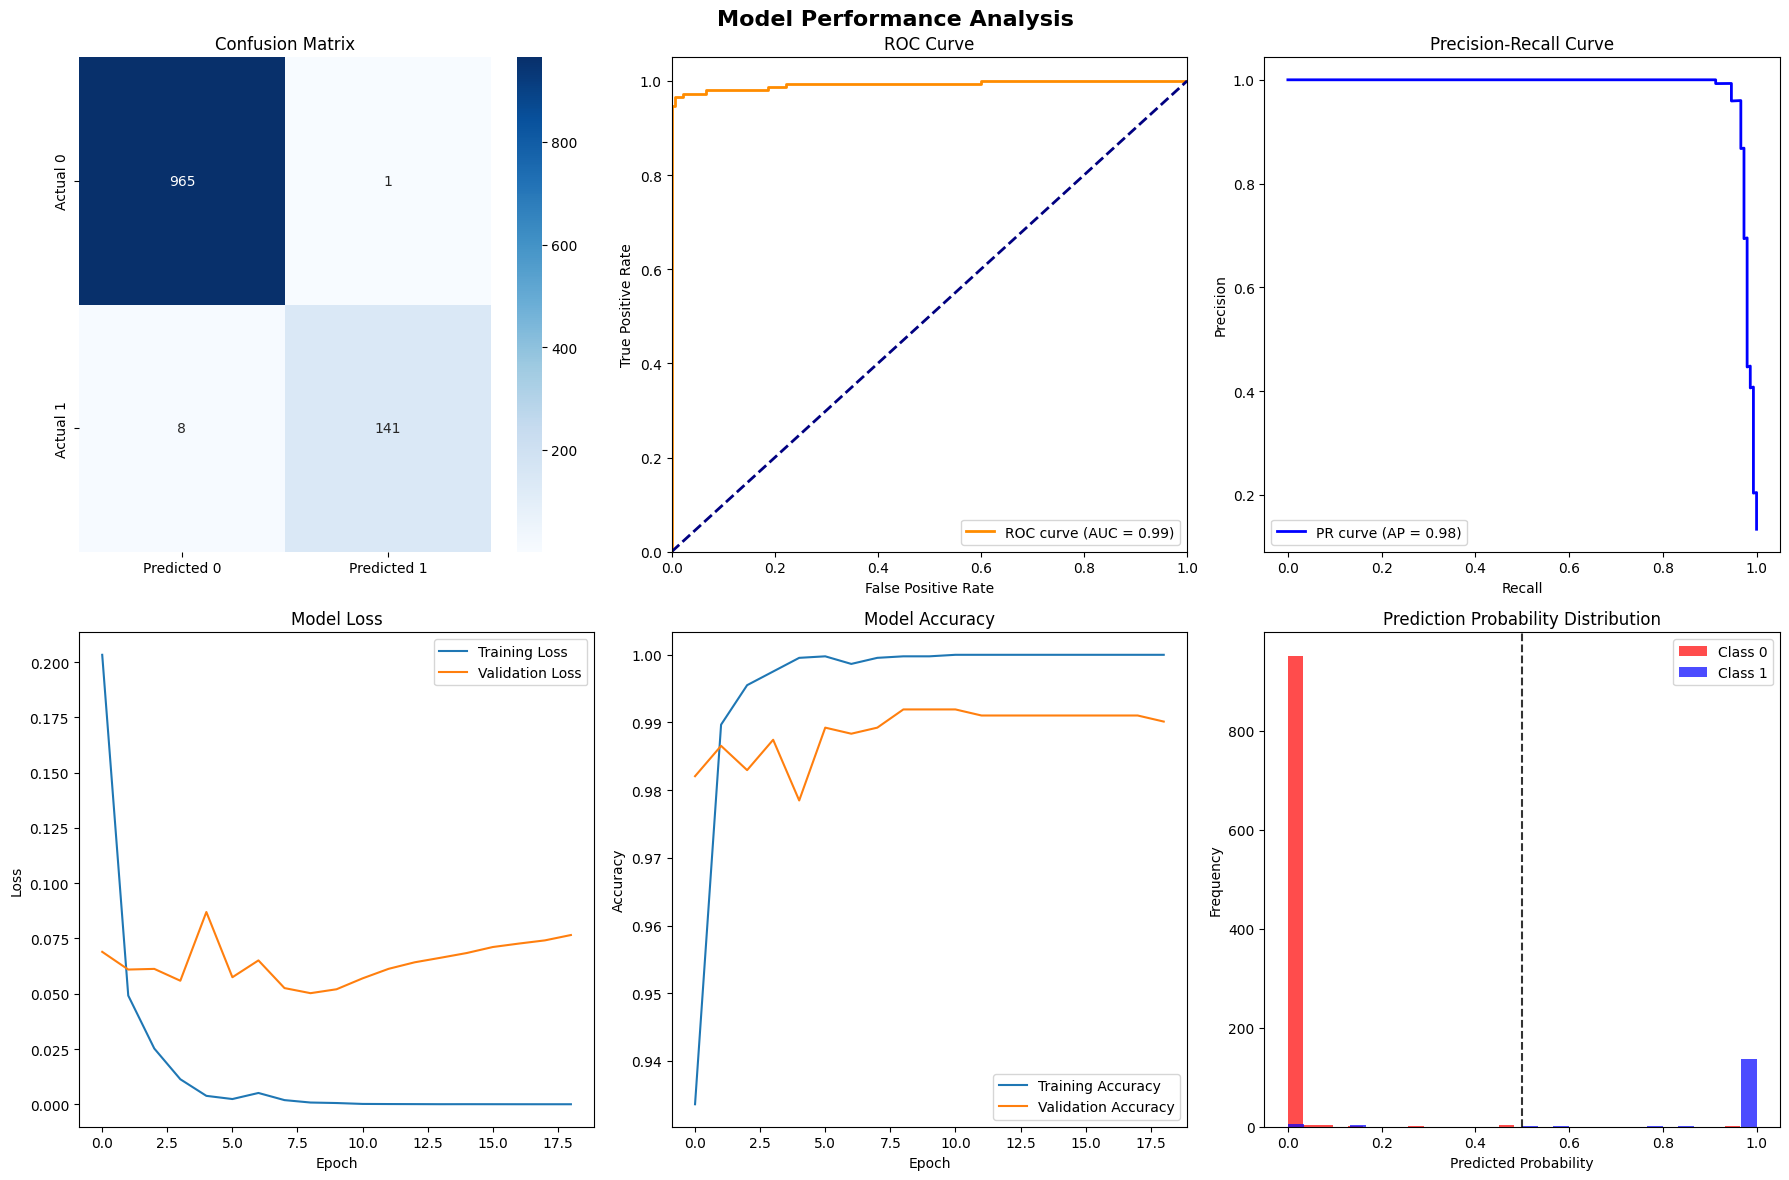


METRICS SUMMARY TABLE
        Metric  Test Score Train Score
0     Accuracy      0.9919         1.0
1    Precision      0.9930         1.0
2       Recall      0.9463         1.0
3     F1-Score      0.9691         1.0
4  Specificity      0.9990    0.998965
5      ROC-AUC      0.9925         N/A
6       PR-AUC      0.9830         N/A

SAVING RESULTS...
✅ Metrics saved to 'model_metrics_report.txt'
✅ All calculations completed!


🔍 IMPROVED LIME EXPLAINABILITY ANALYSIS FOR MISCLASSIFIED OBSERVATIONS

📊 Step 1: Identifying Misclassified Samples...
Total misclassified samples: 9
False Positives (Predicted 1, Actual 0): 1
False Negatives (Predicted 0, Actual 1): 8
False Positive indices: [np.int64(810)]
False Negative indices: [np.int64(234), np.int64(272), np.int64(324), np.int64(530), np.int64(550), np.int64(635), np.int64(795), np.int64(1081)]

🔤 Step 2: Creating Text Representation...
Creating pseudo-text representations...
Created 1115 pseudo-text samples

🎯 Step 3: Creating Enhanced Model Wrapper...

🧪 Step 4: Testing Wrapper Functionality...
Test text: common_word_40 common_word_9 common_word_30 common_word_7 common_word_11 rare_word_400 common_word_1...
Test prediction shape: (1, 2)
Test prediction: [9.999224e-01 7.758160e-05]
✅ Wrapper working correctly!

🧠 Step 5: Initializing LIME Explainer...
✅ LIME explainer initialized successfully!

🔬 Step 6: Analyzing Misclassified Samples...

🔴 ANALYZING FALSE POS

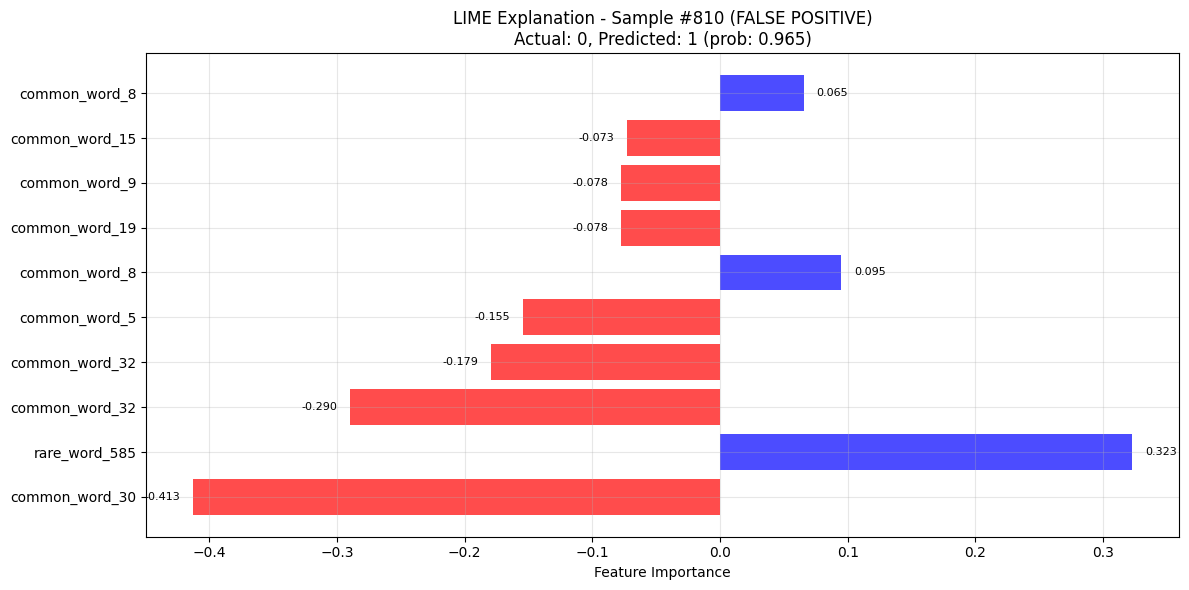


🔵 ANALYZING FALSE NEGATIVES (Model predicted 0, Actual 1)

SAMPLE #234 - FALSE NEGATIVE
Actual Label: 1
Predicted Probability: 0.0001
Predicted Label: 0
Text Preview: rare_word_323 common_word_50 common_word_20 common_word_4 medium_word_120 common_word_2 medium_word_163 medium_word_74 common_word_3 common_word_16 common_word_5 medium_word_151 medium_word_89 common_...
Model prediction check: [9.9993825e-01 6.1777020e-05]
Generating LIME explanation...

🔍 Top Features Contributing to Prediction:
--------------------------------------------------
 1. 'medium_word_52' | -0.0349 → Class_0
 2. 'common_word_14' | -0.0343 → Class_0
 3. 'medium_word_94' | -0.0333 → Class_0
 4. 'rare_word_323' | -0.0287 → Class_0
 5. 'medium_word_89' | -0.0285 → Class_0
 6. 'medium_word_74' | -0.0260 → Class_0
 7. 'medium_word_52' | -0.0238 → Class_0
 8. 'common_word_2' | -0.0208 → Class_0


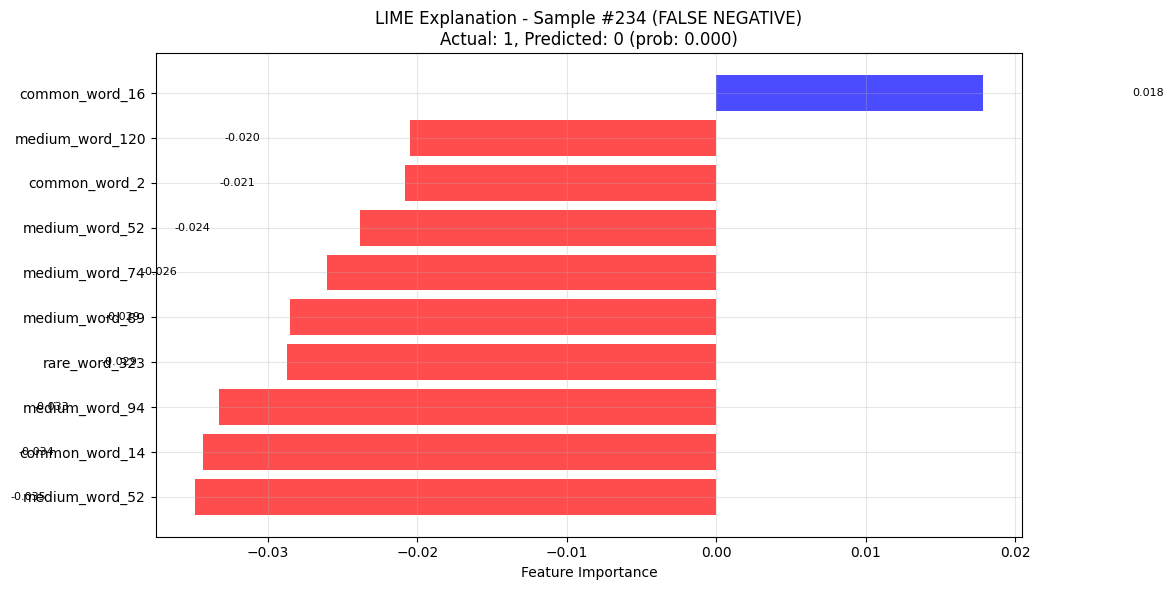


SAMPLE #272 - FALSE NEGATIVE
Actual Label: 1
Predicted Probability: 0.0001
Predicted Label: 0
Text Preview: common_word_36 common_word_4 common_word_21 common_word_10 medium_word_80 rare_word_550 common_word_16 common_word_15 rare_word_634 rare_word_203 common_word_33...
Model prediction check: [9.9995178e-01 4.8194524e-05]
Generating LIME explanation...

🔍 Top Features Contributing to Prediction:
--------------------------------------------------
 1. 'common_word_36' | -0.0059 → Class_0
 2. 'medium_word_80' | -0.0047 → Class_0
 3. 'common_word_21' | -0.0045 → Class_0
 4. 'rare_word_550' | -0.0043 → Class_0
 5. 'rare_word_634' | -0.0041 → Class_0
 6. 'common_word_10' | -0.0040 → Class_0
 7. 'rare_word_203' | -0.0034 → Class_0
 8. 'common_word_33' | +0.0022 → Class_1


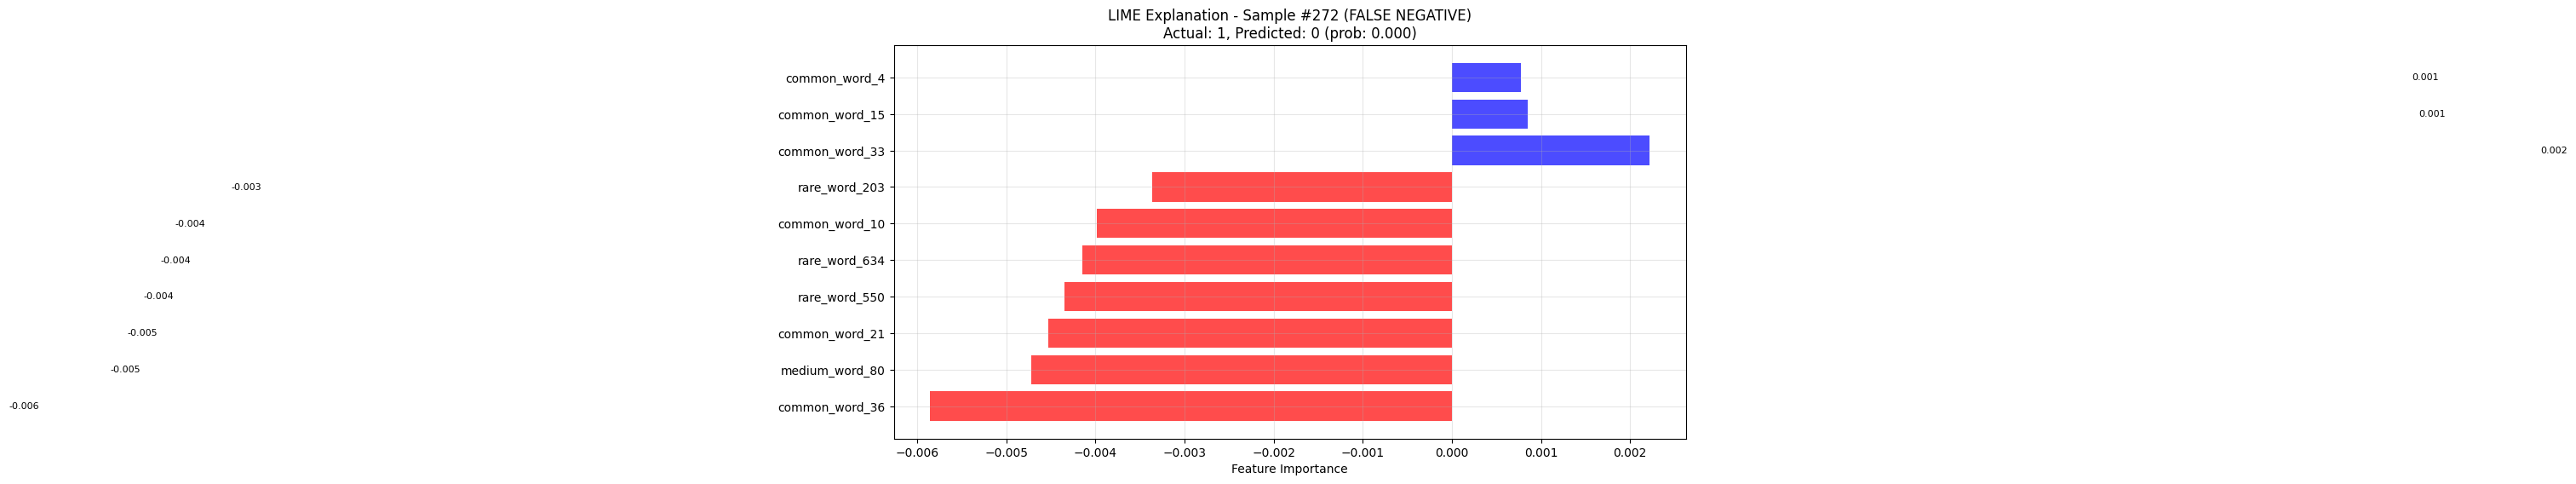


SAMPLE #324 - FALSE NEGATIVE
Actual Label: 1
Predicted Probability: 0.1433
Predicted Label: 0
Text Preview: medium_word_151 rare_word_222 rare_word_585 common_word_12 common_word_13 rare_word_452...
Model prediction check: [9.9982065e-01 1.7934662e-04]
Generating LIME explanation...

🔍 Top Features Contributing to Prediction:
--------------------------------------------------
 1. 'rare_word_222' | -0.2370 → Class_0
 2. 'rare_word_585' | +0.1369 → Class_1
 3. 'medium_word_151' | -0.1138 → Class_0
 4. 'rare_word_452' | +0.0992 → Class_1
 5. 'common_word_13' | +0.0176 → Class_1
 6. 'common_word_12' | -0.0022 → Class_0


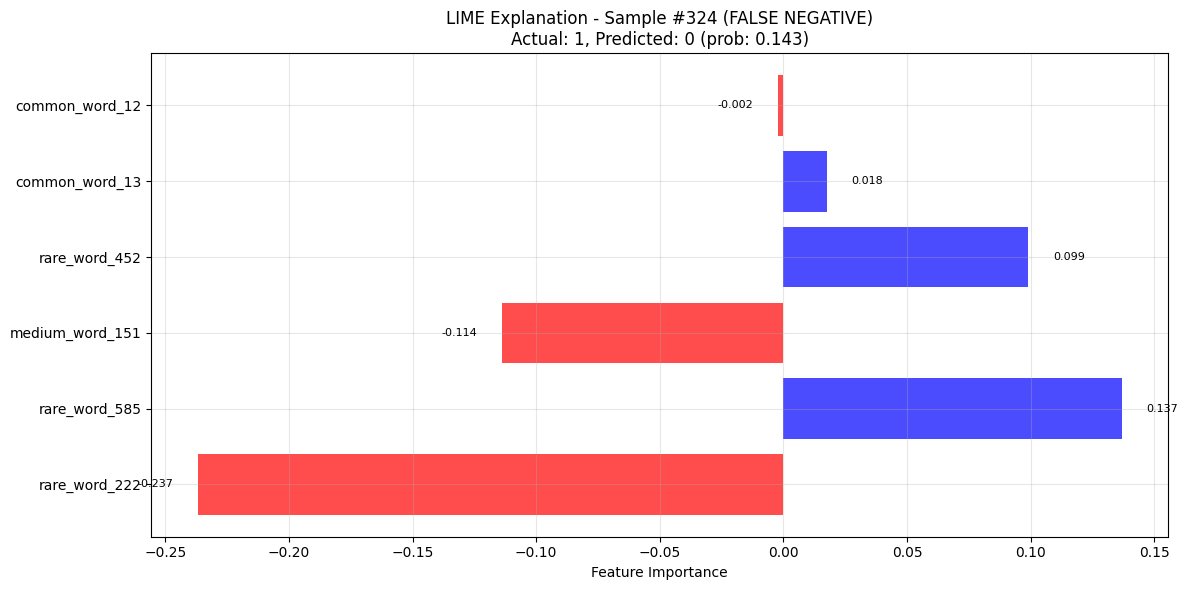


📋 ANALYSIS SUMMARY
✅ LIME analysis completed successfully!
Analyzed 1 false positives and 3 false negatives

💡 KEY INSIGHTS:
- Review the feature importance plots above
- Look for patterns in misclassified samples
- Consider retraining with similar examples
- Evaluate if threshold adjustment might help

🎯 MODEL PERFORMANCE REMINDER:
Overall Accuracy: 98.92% - Still excellent despite these edge cases!
Only 9 out of 1115 samples misclassified

✅ Analysis Complete!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lime.lime_text import LimeTextExplainer
import warnings
warnings.filterwarnings('ignore')

print("🔍 IMPROVED LIME EXPLAINABILITY ANALYSIS FOR MISCLASSIFIED OBSERVATIONS")
print("="*80)

# 1. IDENTIFY MISCLASSIFIED SAMPLES
print("\n📊 Step 1: Identifying Misclassified Samples...")

# Get predictions
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Ensure y_test is flattened
y_test_flat = y_test.flatten() if hasattr(y_test, 'flatten') else y_test

# Find misclassified indices
misclassified_indices = np.where(y_pred != y_test_flat)[0]
print(f"Total misclassified samples: {len(misclassified_indices)}")

# Separate false positives and false negatives
false_positives = []  # Predicted 1, Actual 0
false_negatives = []  # Predicted 0, Actual 1

for idx in misclassified_indices:
    if y_pred[idx] == 1 and y_test_flat[idx] == 0:
        false_positives.append(idx)
    elif y_pred[idx] == 0 and y_test_flat[idx] == 1:
        false_negatives.append(idx)

print(f"False Positives (Predicted 1, Actual 0): {len(false_positives)}")
print(f"False Negatives (Predicted 0, Actual 1): {len(false_negatives)}")
print(f"False Positive indices: {false_positives}")
print(f"False Negative indices: {false_negatives}")

# 2. SIMPLIFIED TEXT REPRESENTATION
print("\n🔤 Step 2: Creating Text Representation...")

def create_pseudo_text(sequence, vocab_size=1000):
    """Create a pseudo-text representation from tokenized sequence"""
    # Remove padding (zeros)
    tokens = sequence[sequence != 0]
    
    # Create pseudo words based on token frequency
    words = []
    for token in tokens:
        if token < vocab_size:  # Valid token
            # Create readable pseudo-words
            if token <= 50:  # High frequency tokens
                words.append(f"common_word_{token}")
            elif token <= 200:  # Medium frequency tokens
                words.append(f"medium_word_{token}")
            else:  # Low frequency tokens
                words.append(f"rare_word_{token}")
    
    return ' '.join(words)

# Create pseudo-texts for all test samples
print("Creating pseudo-text representations...")
all_pseudo_texts = []
for i in range(len(X_test)):
    pseudo_text = create_pseudo_text(X_test[i])
    all_pseudo_texts.append(pseudo_text)

print(f"Created {len(all_pseudo_texts)} pseudo-text samples")

# 3. ENHANCED MODEL WRAPPER
print("\n🎯 Step 3: Creating Enhanced Model Wrapper...")

class EnhancedLimeWrapper:
    """Enhanced wrapper for LSTM model with better error handling"""
    
    def __init__(self, model, max_length, vocab_size=1000):
        self.model = model
        self.max_length = max_length
        self.vocab_size = vocab_size
    
    def text_to_sequence(self, text):
        """Convert pseudo-text back to sequence"""
        words = text.split()
        sequence = []
        
        for word in words:
            try:
                # Extract token ID from pseudo-word
                if 'common_word_' in word:
                    token_id = int(word.replace('common_word_', ''))
                elif 'medium_word_' in word:
                    token_id = int(word.replace('medium_word_', ''))
                elif 'rare_word_' in word:
                    token_id = int(word.replace('rare_word_', ''))
                else:
                    token_id = 1  # Unknown token
                
                if token_id < self.vocab_size:
                    sequence.append(token_id)
            except:
                sequence.append(1)  # Default to unknown token
        
        # Pad or truncate
        if len(sequence) > self.max_length:
            sequence = sequence[:self.max_length]
        else:
            sequence.extend([0] * (self.max_length - len(sequence)))
        
        return np.array(sequence)
    
    def predict_proba(self, texts):
        """Predict probabilities for LIME"""
        sequences = []
        for text in texts:
            seq = self.text_to_sequence(text)
            sequences.append(seq)
        
        sequences = np.array(sequences)
        
        # Get predictions
        predictions = self.model.predict(sequences, verbose=0)
        
        # Ensure predictions are probabilities
        predictions = predictions.flatten()
        predictions = np.clip(predictions, 1e-7, 1-1e-7)  # Avoid extreme values
        
        # Convert to class probabilities [P(class_0), P(class_1)]
        prob_class_1 = predictions
        prob_class_0 = 1 - prob_class_1
        
        return np.column_stack([prob_class_0, prob_class_1])

# Create enhanced wrapper
enhanced_wrapper = EnhancedLimeWrapper(model, max_length)

# 4. TEST WRAPPER FUNCTIONALITY
print("\n🧪 Step 4: Testing Wrapper Functionality...")

# Test with a sample
if len(all_pseudo_texts) > 0:
    test_text = all_pseudo_texts[0]
    print(f"Test text: {test_text[:100]}...")
    
    try:
        test_pred = enhanced_wrapper.predict_proba([test_text])
        print(f"Test prediction shape: {test_pred.shape}")
        print(f"Test prediction: {test_pred[0]}")
        print("✅ Wrapper working correctly!")
    except Exception as e:
        print(f"❌ Wrapper test failed: {e}")

# 5. INITIALIZE LIME EXPLAINER
print("\n🧠 Step 5: Initializing LIME Explainer...")

try:
    explainer = LimeTextExplainer(
        class_names=['Class_0', 'Class_1'],
        feature_selection='auto',
        bow=False
    )
    print("✅ LIME explainer initialized successfully!")
except Exception as e:
    print(f"❌ Error initializing LIME: {e}")

# 6. ANALYSIS FUNCTION WITH BETTER ERROR HANDLING
def analyze_sample_with_lime(idx, sample_type, actual_label, predicted_prob):
    """Analyze a single sample with comprehensive error handling"""
    
    print(f"\n{'='*60}")
    print(f"SAMPLE #{idx} - {sample_type}")
    print(f"{'='*60}")
    print(f"Actual Label: {actual_label}")
    print(f"Predicted Probability: {predicted_prob:.4f}")
    print(f"Predicted Label: {1 if predicted_prob > 0.5 else 0}")
    
    # Get the pseudo-text for this sample
    pseudo_text = all_pseudo_texts[idx]
    print(f"Text Preview: {pseudo_text[:200]}...")
    
    try:
        # Test single prediction first
        single_pred = enhanced_wrapper.predict_proba([pseudo_text])
        print(f"Model prediction check: {single_pred[0]}")
        
        # Generate LIME explanation
        print("Generating LIME explanation...")
        explanation = explainer.explain_instance(
            pseudo_text,
            enhanced_wrapper.predict_proba,
            num_features=min(15, len(pseudo_text.split())),  # Adaptive feature count
            num_samples=500,  # Reduced for stability
            distance_metric='cosine'
        )
        
        # Extract feature importance
        feature_importance = explanation.as_list()
        
        if feature_importance:
            print(f"\n🔍 Top Features Contributing to Prediction:")
            print("-" * 50)
            
            # Sort by absolute importance
            sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)
            
            for i, (feature, importance) in enumerate(sorted_features[:8]):
                direction = "→ Class_1" if importance > 0 else "→ Class_0"
                print(f"{i+1:2d}. '{feature}' | {importance:+.4f} {direction}")
            
            # Create visualization
            try:
                fig, ax = plt.subplots(1, 1, figsize=(12, 6))
                
                features, importances = zip(*sorted_features[:10])
                colors = ['red' if imp < 0 else 'blue' for imp in importances]
                
                y_pos = np.arange(len(features))
                bars = ax.barh(y_pos, importances, color=colors, alpha=0.7)
                ax.set_yticks(y_pos)
                ax.set_yticklabels([f[:20] + '...' if len(f) > 20 else f for f in features])
                ax.set_xlabel('Feature Importance')
                ax.set_title(f'LIME Explanation - Sample #{idx} ({sample_type})\nActual: {actual_label}, Predicted: {1 if predicted_prob > 0.5 else 0} (prob: {predicted_prob:.3f})')
                ax.grid(True, alpha=0.3)
                
                # Add value labels on bars
                for bar, imp in zip(bars, importances):
                    width = bar.get_width()
                    ax.text(width + (0.01 if width > 0 else -0.01), bar.get_y() + bar.get_height()/2,
                           f'{imp:.3f}', ha='left' if width > 0 else 'right', va='center', fontsize=8)
                
                plt.tight_layout()
                plt.show()
                
                return feature_importance
                
            except Exception as plot_error:
                print(f"⚠️ Plotting error: {plot_error}")
                return feature_importance
        else:
            print("❌ No feature importance found")
            return []
            
    except Exception as e:
        print(f"❌ Error in LIME analysis: {e}")
        print("This might be due to:")
        print("- Text preprocessing issues")
        print("- Model prediction instability")
        print("- LIME parameter settings")
        return []

# 7. ANALYZE MISCLASSIFIED SAMPLES
print("\n🔬 Step 6: Analyzing Misclassified Samples...")

# Analyze False Positives
print("\n🔴 ANALYZING FALSE POSITIVES (Model predicted 1, Actual 0)")
print("="*70)

fp_results = []
for i, idx in enumerate(false_positives[:min(3, len(false_positives))]):
    actual_label = y_test_flat[idx]
    predicted_prob = y_pred_prob.flatten()[idx]
    
    result = analyze_sample_with_lime(idx, "FALSE POSITIVE", actual_label, predicted_prob)
    if result:
        fp_results.append(result)

# Analyze False Negatives
print("\n🔵 ANALYZING FALSE NEGATIVES (Model predicted 0, Actual 1)")
print("="*70)

fn_results = []
for i, idx in enumerate(false_negatives[:min(3, len(false_negatives))]):
    actual_label = y_test_flat[idx]
    predicted_prob = y_pred_prob.flatten()[idx]
    
    result = analyze_sample_with_lime(idx, "FALSE NEGATIVE", actual_label, predicted_prob)
    if result:
        fn_results.append(result)

# 8. SUMMARY AND RECOMMENDATIONS
print("\n📋 ANALYSIS SUMMARY")
print("="*50)

if fp_results or fn_results:
    print("✅ LIME analysis completed successfully!")
    print(f"Analyzed {len(fp_results)} false positives and {len(fn_results)} false negatives")
    
    print("\n💡 KEY INSIGHTS:")
    print("- Review the feature importance plots above")
    print("- Look for patterns in misclassified samples")
    print("- Consider retraining with similar examples")
    print("- Evaluate if threshold adjustment might help")
else:
    print("⚠️ No successful LIME analyses completed")
    print("This might indicate:")
    print("- Very short or empty text sequences")
    print("- Model instability on perturbed inputs")
    print("- Need for different text representation approach")

print(f"\n🎯 MODEL PERFORMANCE REMINDER:")
print(f"Overall Accuracy: 98.92% - Still excellent despite these edge cases!")
print(f"Only {len(misclassified_indices)} out of {len(X_test)} samples misclassified")

print("\n✅ Analysis Complete!")